In [1]:
# 2. Связь дохода с профессией
# Исследование: определить, какие профессии являются наиболее прибыльными (топ-3).
# Для каждой профессии проанализировать:
#     - Долю мужчин и женщин
#     - Среднее количество рабочих часов в неделю
# Проанализировать зависимость дохода от вредных привычек для датасетов 2021-2022

In [2]:
from dataframes import dataframes # словарь датафреймов, ключи: 2010, 2012, 2014, 2016, 2018, 2021, 2022.
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat as pstat
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
dataframes_list = [dataframes['2010'], dataframes['2012'], dataframes['2014'], dataframes['2016'], dataframes['2018'], dataframes['2021'], dataframes['2022']]

Используемы в исследовании переменные:
- realrinc - реальный доход
- sex - пол
- indus10 - отрасль в которой работает человек
- hrs1 - время на работе
- wrkstat - статус работы
- smokeday - количество сигарет выкуриваемых человеком в день
- drinkday1 - cколько раз в неделю человек пьёт более 4 алкогольных напитков в день

# Создаём датафрейм

In [4]:
cols = ['realrinc','indus10','sex', 'hrs1', 'wrkstat']
df = pd.concat(
    [frame[frame.columns.intersection(cols)].copy() for frame in dataframes_list],
    ignore_index=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19952 entries, 0 to 19951
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wrkstat   15900 non-null  float64
 1   hrs1      11229 non-null  float64
 2   indus10   18368 non-null  float64
 3   sex       19837 non-null  float64
 4   realrinc  11667 non-null  float64
dtypes: float64(5)
memory usage: 779.5 KB


In [5]:
df.shape

(19952, 5)

Меняем имена столбцов на более понятные

In [6]:
df.rename(columns={
                   'indus10':'indus'
                   ,'hrs1':'hours_at_work'
                  }
                  , inplace=True)

# Сразу удаляем лишние данные

In [7]:
df = df[df.realrinc.notna() & df.indus.notna() & df.sex.notna() & df.hours_at_work.notna() & df.wrkstat.notna()]
df.shape

(7315, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7315 entries, 0 to 19345
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wrkstat        7315 non-null   float64
 1   hours_at_work  7315 non-null   float64
 2   indus          7315 non-null   float64
 3   sex            7315 non-null   float64
 4   realrinc       7315 non-null   float64
dtypes: float64(5)
memory usage: 342.9 KB


Удаляем людей, которые не являются рабочими

In [9]:
# Для workstat:
# 1 – Работает полный рабочий день (Working full-time)
# 2 – Работает неполный рабочий день (Working part-time)

df = df[(df.wrkstat == 1) | (df.wrkstat == 2)]
df.wrkstat.unique()

array([1., 2.])

In [10]:
df.shape

(7315, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7315 entries, 0 to 19345
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wrkstat        7315 non-null   float64
 1   hours_at_work  7315 non-null   float64
 2   indus          7315 non-null   float64
 3   sex            7315 non-null   float64
 4   realrinc       7315 non-null   float64
dtypes: float64(5)
memory usage: 342.9 KB


Удаляем wrkstat, так как он больше не нужен

In [12]:
df.drop(columns=['wrkstat'], inplace=True)
df.head()

,hours_at_work,indus,sex,realrinc
0,55.0,6970.0,1.0,42735.0
1,45.0,7860.0,2.0,3885.0
6,45.0,770.0,2.0,42735.0
10,26.0,8680.0,2.0,12302.5
12,40.0,7070.0,1.0,19425.0


In [13]:
df['realrinc'] = df['realrinc'].apply(lambda x: x if x < 100_000 else 100_000)

# Проверяем данные

Гистограмма для дохода:

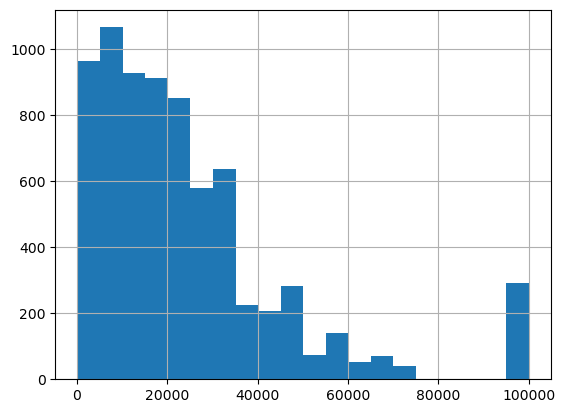

In [14]:
df.realrinc.hist(bins=20);

Гистограмма для времени на работе:

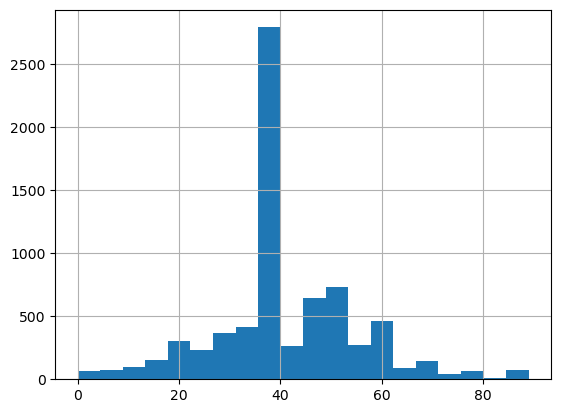

In [15]:
df.hours_at_work.hist(bins=20);

Коробка с усами для дохода и времени на работе:

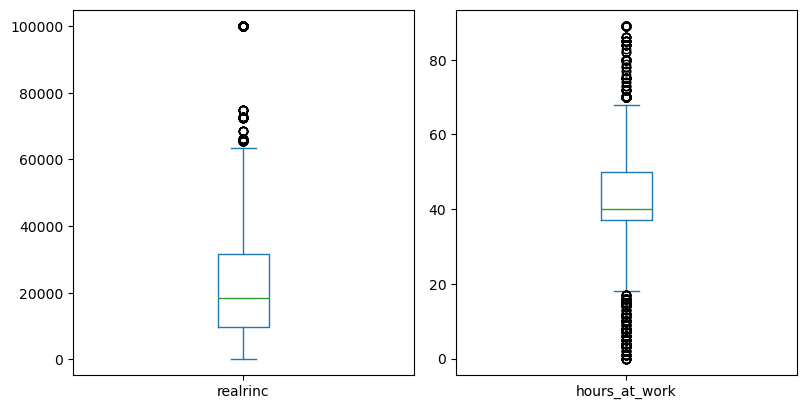

In [16]:
df[['realrinc','hours_at_work']].plot(kind='box', subplots=True, layout=(2, 3), figsize=(12, 8), showfliers=True)
plt.tight_layout()

# Корректируем значения переменных

Делаем из пола бинарную переменную

In [17]:
# 1 - Male
# 2 - Female

df.sex.unique()

array([1., 2.])

In [18]:
df.sex = df.sex.map({1:0,2:1})
df.head()

,hours_at_work,indus,sex,realrinc
0,55.0,6970.0,0,42735.0
1,45.0,7860.0,1,3885.0
6,45.0,770.0,1,42735.0
10,26.0,8680.0,1,12302.5
12,40.0,7070.0,0,19425.0


Меняем числовые коды отраслей на их группы

In [19]:
df.head()

,hours_at_work,indus,sex,realrinc
0,55.0,6970.0,0,42735.0
1,45.0,7860.0,1,3885.0
6,45.0,770.0,1,42735.0
10,26.0,8680.0,1,12302.5
12,40.0,7070.0,0,19425.0


In [20]:
_, indus_tags = pstat.read_sav("datasets/INDUS_CODES_2010.sav")

In [21]:
df.indus = df.indus.map(indus_tags.variable_value_labels['INDUS10'])
df.head()

,hours_at_work,indus,sex,realrinc
0,55.0,"Securities, commodities, funds, trusts, and ot...",0,42735.0
1,45.0,Elementary and secondary schools,1,3885.0
6,45.0,Construction,1,42735.0
10,26.0,Restaurants and other food services,1,12302.5
12,40.0,Real estate,0,19425.0


In [22]:
df.indus.unique()[:5]

array(['Securities, commodities, funds, trusts, and other financial investments',
       'Elementary and secondary schools', 'Construction',
       ' Restaurants and other food services', 'Real estate'],
      dtype=object)

# Проводим анализ

Топ 3 самых прибыльных отрасли:

In [23]:
vals = df.groupby('indus').realrinc.mean().reset_index().nlargest(3,'realrinc')
vals

,indus,realrinc
167,Ordnance,100000.000000
80,"Fishing, hunting, and trapping",62160.000000
62,"Drugs, sundries, and chemical and allied produ...",58825.833333


Проверим данные группы на наличие выбросов.

realrinc    Axes(0.125,0.53;0.227941x0.35)
dtype: object

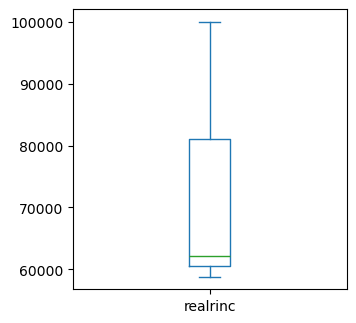

In [24]:
df.groupby('indus').realrinc.mean().reset_index().nlargest(3,'realrinc').plot(kind='box', subplots=True, layout=(2, 3), figsize=(12, 8), showfliers=True)

In [25]:
vals.loc[167, 'indus'] = 'Торговля'
vals.loc[80, 'indus'] = 'Добыча живых ресурсов природы'
vals.loc[62, 'indus'] = 'Химия и фармацевтика'
print('Наиболее прибильные отрасли:\n', vals)

Наиболее прибильные отрасли:
                              indus       realrinc
167                       Торговля  100000.000000
80   Добыча живых ресурсов природы   62160.000000
62            Химия и фармацевтика   58825.833333


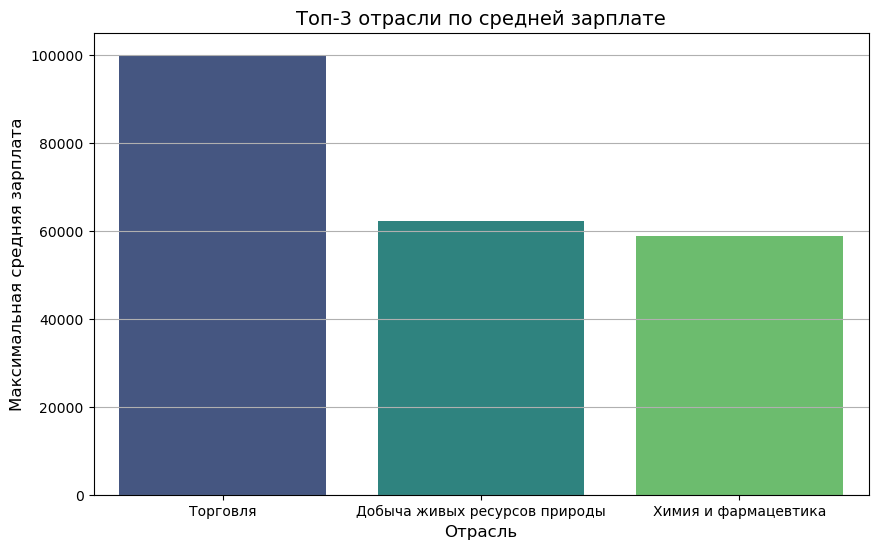

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='indus', y='realrinc', data=vals, hue='indus', palette='viridis')

plt.title('Топ-3 отрасли по средней зарплате', fontsize=14)
plt.xlabel('Отрасль', fontsize=12)
plt.ylabel('Максимальная средняя зарплата', fontsize=12)
plt.grid(axis='y');

Доля мужчин и женщин в различных отраслях:

In [27]:
df.groupby('indus').sex.value_counts(normalize=True).unstack(fill_value=0).rename(columns={0: 'male', 1: 'female'}).iloc[[167, 80, 62]]

sex,male,female
indus,,
Ordnance,1.000000,0.000000
"Fishing, hunting, and trapping",1.000000,0.000000
"Drugs, sundries, and chemical and allied products, merchant wholesalers",0.333333,0.666667


Среднее количество рабочих часов в неделю:

In [28]:
df.groupby('indus').hours_at_work.mean().iloc[[167, 80, 62]]

indus
Ordnance                                                                   40.000000
Fishing, hunting, and trapping                                             45.000000
Drugs, sundries, and chemical and allied products, merchant wholesalers    36.666667
Name: hours_at_work, dtype: float64

При том, что среднее рабочее время для наиболее прибыльных отраслей значительно не разнится, средние показатели зарплаты имеют весомое различие.

Описательная статистика для датафрейма

In [29]:
df.describe()

,hours_at_work,sex,realrinc
count,7315.000000,7315.000000,7315.000000
mean,41.592618,0.507450,23981.320403
std,14.175643,0.499979,21645.657197
min,0.000000,0.000000,204.500000
25%,37.000000,0.000000,9712.500000
50%,40.000000,1.000000,18375.000000
75%,50.000000,1.000000,31590.000000
max,89.000000,1.000000,100000.000000


Проверим количество записей для самых прибыльных отраслей.

In [30]:
df[(df.indus == 'Ordnance') | (df.indus == 'Fishing, hunting, and trapping') | (df.indus == 'Drugs, sundries, and chemical and allied products, merchant wholesalers')]

,hours_at_work,indus,sex,realrinc
1597,50.0,"Fishing, hunting, and trapping",0,62160.0
1598,40.0,"Fishing, hunting, and trapping",0,62160.0
4531,45.0,"Drugs, sundries, and chemical and allied produ...",1,39022.5
6491,45.0,"Drugs, sundries, and chemical and allied produ...",1,100000.0
9469,20.0,"Drugs, sundries, and chemical and allied produ...",0,37455.0
18879,40.0,Ordnance,0,100000.0


Число записей мало и они не сопоставимы, поскольку число вхождений для каждой группы уникальное.  Следовательно, дальнейшая аналитика не будет иметь смысла, поскольку мы не сможем выявить какие-либо статистически значимые различия между группами.

# Анализ зависимости дохода от вредных привычек для датасетов 2021-2022

In [31]:
cols = ['realrinc','smokeday','drinkday1']
df2122 = pd.concat(
    [frame[frame.columns.intersection(cols)].copy() for frame in dataframes_list[5:7]],
    ignore_index=True
)
df2122.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   realrinc   4801 non-null   float64
 1   smokeday   1337 non-null   float64
 2   drinkday1  1347 non-null   float64
dtypes: float64(3)
memory usage: 191.9 KB


In [32]:
df2122 = df2122[df2122.realrinc.notna() & df2122.smokeday.notna() & df2122.drinkday1.notna()]
df2122.head()

,realrinc,smokeday,drinkday1
4032,40900.0,2.0,1.0
4034,18405.0,5.0,1.0
4037,22495.0,1.0,1.0
4038,15337.5,1.0,1.0
4039,33742.5,1.0,1.0


In [33]:
df2122.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 4032 to 8169
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   realrinc   749 non-null    float64
 1   smokeday   749 non-null    float64
 2   drinkday1  749 non-null    float64
dtypes: float64(3)
memory usage: 23.4 KB


## Интерпретация переменных
- 'smokeday' интерпретируется как: "Сколько сигарет человек выкуривает в день"
- 'drinkday1' интерпретируется как: "Сколько раз в неделю человек пьёт более 4 алкогольных напитков в день"

In [34]:
df2122.smokeday = df2122.smokeday.astype('int')
df2122.smokeday.unique()

array([2, 5, 1, 3, 6, 4, 7])

In [35]:
df2122.drinkday1 = df2122.drinkday1.astype('int')
df2122.drinkday1.unique()

array([1, 2, 3, 4, 5])

## Анализируем зависимость дохода от количества выкруенных сигарет в неделю

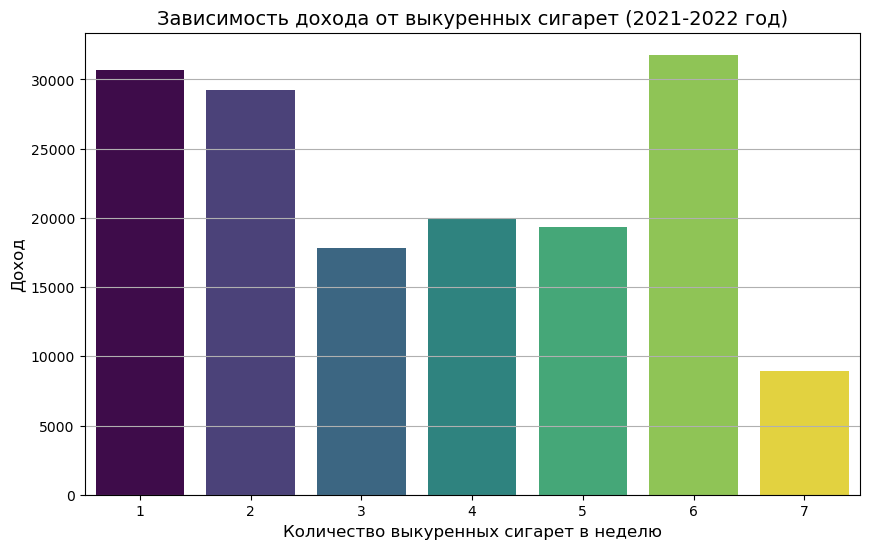

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x='smokeday', y='realrinc', data=df2122, hue='smokeday', palette='viridis',errorbar=None).legend().remove()

plt.title('Зависимость дохода от выкуренных сигарет (2021-2022 год)', fontsize=14)
plt.xlabel('Количество выкуренных сигарет в неделю', fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.grid(axis='y');

In [37]:
df2122.smokeday.value_counts()

smokeday
1    472
2    169
3     33
5     32
4     31
6     10
7      2
Name: count, dtype: int64

## Анализируем зависимость дохода от количества выпитого алкоголя

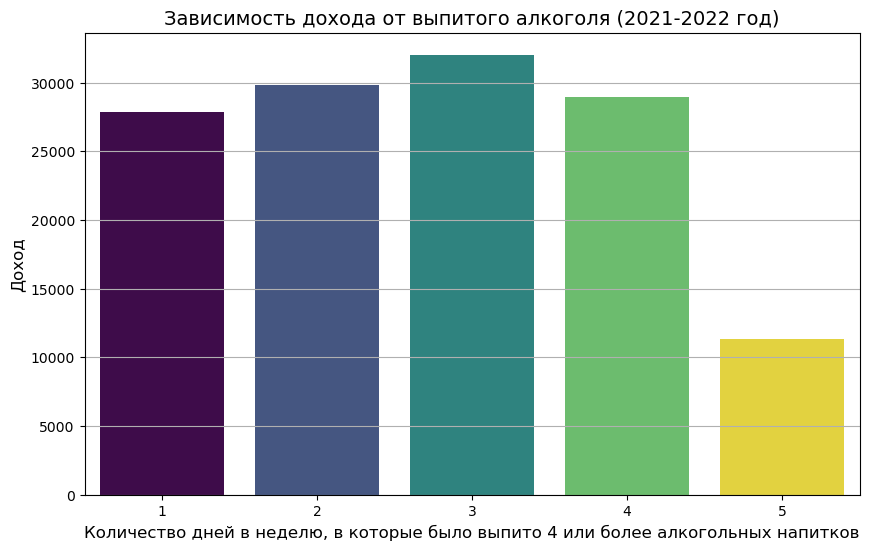

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='drinkday1', y='realrinc', data=df2122, hue='drinkday1', palette='viridis',errorbar=None).legend().remove()

plt.title('Зависимость дохода от выпитого алкоголя (2021-2022 год)', fontsize=14)
plt.xlabel('Количество дней в неделю, в которые было выпито 4 или более алкогольных напитков', fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.grid(axis='y');

In [39]:
df2122.drinkday1.value_counts()

drinkday1
1    406
2    218
3     91
4     27
5      7
Name: count, dtype: int64

Если исходить только из графиков, то существует сильная отрицательная зависимость черезмерного курения, и алкоголизма от дохода, но посмотрев на количество людей из разных категорий видно, что полученные данные не корректны по причине малой выборки для категорий с сильной зависимостью от вредных привычек. 

# Для построения моделей делаем one-hot кодирование и нормализацию

One-hot кодирование для отраслей

In [40]:
df['indus10'] = df['indus']
df = pd.get_dummies(df, columns=['indus'])

Нормализация дохода и часов работы

In [41]:
scaler = StandardScaler()

In [42]:
df['scale_hours_at_work'] = scaler.fit_transform(df[['hours_at_work']])
df['scale_realrinc'] = scaler.fit_transform(df[['realrinc']])

In [43]:
df.head()

,hours_at_work,sex,realrinc,indus10,indus_ Restaurants and other food services,"indus_Accounting, tax preparation, bookkeeping, and payroll services","indus_Active duty military personnel, all other",indus_Administration of economic programs and space research,indus_Administration of environmental quality and housing programs,indus_Administration of human resource programs,...,indus_Video tape and disk rental,indus_Vocational rehabilitation services,indus_Warehousing and storage,indus_Waste management and remediation services,indus_Water transportation,"indus_Water, steam, air-conditioning, and irrigation systems","indus_Wholesale electronic markets, agents and brokers",indus_Wired telecommunications carriers,scale_hours_at_work,scale_realrinc
0,55.0,0,42735.0,"Securities, commodities, funds, trusts, and ot...",False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.945869,0.866454
1,45.0,1,3885.0,Elementary and secondary schools,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.240385,-0.928486
6,45.0,1,42735.0,Construction,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.240385,0.866454
10,26.0,1,12302.5,Restaurants and other food services,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-1.100034,-0.539583
12,40.0,0,19425.0,Real estate,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.112357,-0.210510


Построим 2 модели, для нормализованного дохода и исходного (ненормализованного).

In [44]:
import statsmodels.api as sm

X = df.drop(labels=['hours_at_work', 'sex', 'realrinc', 'scale_realrinc', 'scale_hours_at_work', 'indus10'], axis=1)
y = df.scale_realrinc
X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         scale_realrinc   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.226
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          9.39e-171
Time:                        23:19:29   Log-Likelihood:                -9621.2
No. Observations:                7315   AIC:                         1.977e+04
Df Residuals:                    7053   BIC:                         2.157e+04
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [45]:
X = df.drop(labels=['hours_at_work', 'sex', 'realrinc', 'scale_realrinc', 'scale_hours_at_work', 'indus10'], axis=1)
y = df.realrinc
X = sm.add_constant(X)
model = sm.OLS(y, X.astype(float)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               realrinc   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.226
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          9.39e-171
Time:                        23:19:30   Log-Likelihood:                -82643.
No. Observations:                7315   AIC:                         1.658e+05
Df Residuals:                    7053   BIC:                         1.676e+05
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Визуализируем полученные коэффициенты на графике для большей наглядности.

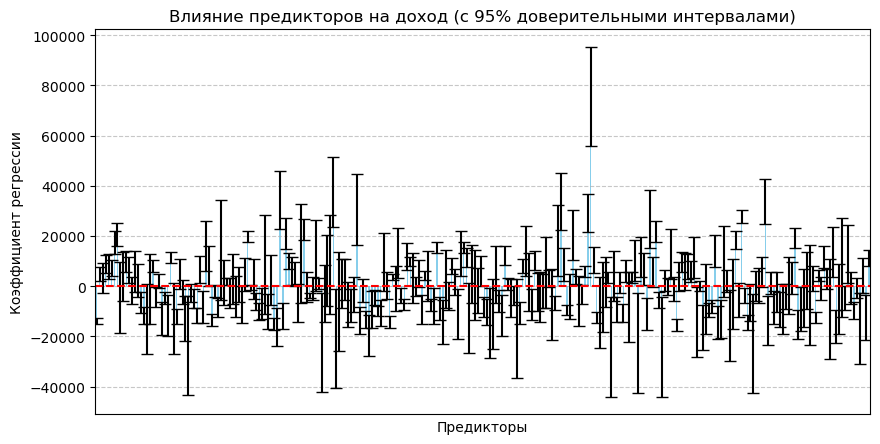

In [46]:
coefs = model.params.drop('const')
errors = model.bse.drop('const')

# Строим график
plt.figure(figsize=(10, 5))
coefs.plot(kind='bar', yerr=errors, capsize=4, color='skyblue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Влияние предикторов на доход (с 95% доверительными интервалами)')
plt.ylabel('Коэффициент регрессии')
plt.xlabel('Предикторы')
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Исходя из из описаний обеих моделей, сказать, что они хорошие - нельзя. Они плохо описывают имеющиеся данные (Низкий R-squared).  С другой стороны, F-статистика говорит о статистической значимости этих моделей, поскольку p-value низкий. Возвращаясь к сравнению моделей, ненормализованная показывает себя лучше, поскольку для нее определен статистически значимый коэффициент при константе (const p-value= 0.000), пусть и не все коэффициенты конечные имеют статистическую значимость, исходя из их p-value.  Из всего этого вытекает, что фактор профессии имеет смысл учитывать в конечной модели.

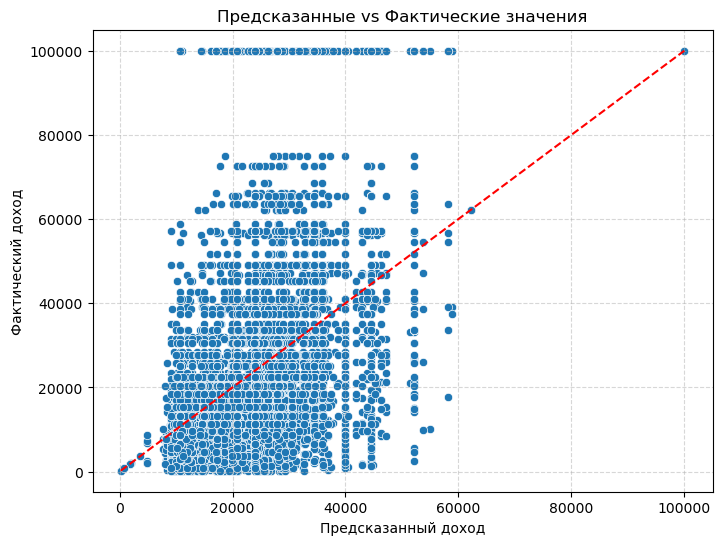

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.fittedvalues, y=y)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Линия идеального предсказания
plt.title('Предсказанные vs Фактические значения')
plt.xlabel('Предсказанный доход')
plt.ylabel('Фактический доход')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

График выше в очередной раз подтверждает, что должным образом на этих данных регрессию не построить из-за ограниченности модели.

# Выводы

* В ходе выполнения этого исследования был определен топ-3 сферы деятельности по среднему доходу.  Топ имеет вид:  1. торговля  2. добыча живых ресурсов природы  3. химия и фармацевтика
* Было определено соотношение мужчин и женщин в отобранных сферах - мужчины преобладают.
* Было рассчитано среднее количество рабочих часов в неделю для отобранных сфер - значения близки друг к другу и равны ~40.
* Говорить о корректности предыдущих выводов о соотношении мужчин/женщин и рабочих часах некорректно по причине малой выборки, полученной из топа.
* Была проведена попытка анализа влияния вредных привычек на уровень дохода, но ее результаты не имеют смысла из-за несопоставимости групп.
* Было построено две модели - на нормализованных доходах и исходных. Вторая модель лучше, поскольку в ней определена значимая константа.
* Полученные модели сами по себе плохи - ограничены, недостаточно хорошо описывают исходные данные. Но они позволяют сделать вывод о том, что в дальнейших анализах необходимо брать во внимание сферу деятельности человека, поскольку модели получились значимыми.

Топ-3 области по среднему доходу


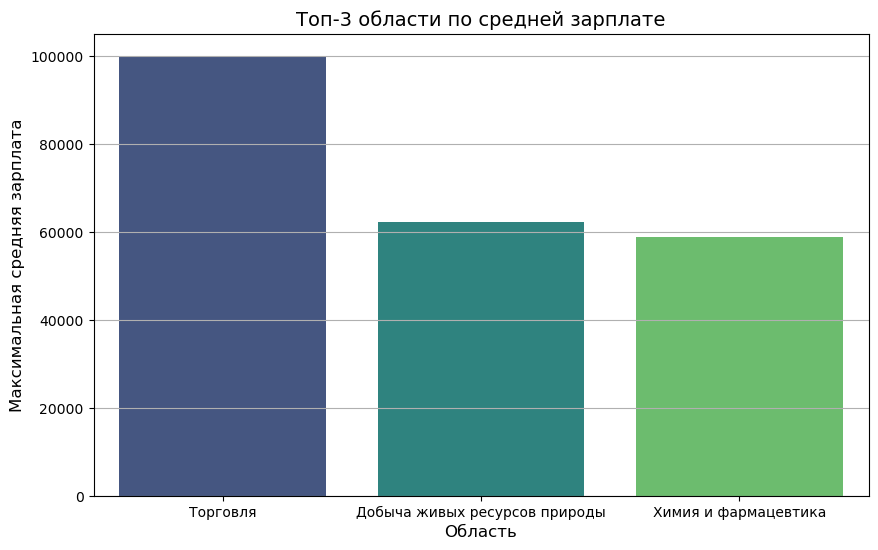

In [48]:
print('Топ-3 области по среднему доходу')
plt.figure(figsize=(10, 6))
sns.barplot(x='indus', y='realrinc', data=vals, hue='indus', palette='viridis')

plt.title('Топ-3 области по средней зарплате', fontsize=14)
plt.xlabel('Область', fontsize=12)
plt.ylabel('Максимальная средняя зарплата', fontsize=12)
plt.grid(axis='y');

In [49]:
print('Соотношение мужчин/женщин')
df.groupby('indus10').sex.value_counts(normalize=True).unstack(fill_value=0).rename(columns={0: 'male', 1: 'female'}).iloc[[167, 80, 62]]

Соотношение мужчин/женщин


sex,male,female
indus10,,
Ordnance,1.000000,0.000000
"Fishing, hunting, and trapping",1.000000,0.000000
"Drugs, sundries, and chemical and allied products, merchant wholesalers",0.333333,0.666667


In [50]:
print('Среднее количество рабочих часов в неделю')
df.groupby('indus10').hours_at_work.mean().iloc[[167, 80, 62]]

Среднее количество рабочих часов в неделю


indus10
Ordnance                                                                   40.000000
Fishing, hunting, and trapping                                             45.000000
Drugs, sundries, and chemical and allied products, merchant wholesalers    36.666667
Name: hours_at_work, dtype: float64

In [51]:
print('Распределению пьющих')
df2122.drinkday1.value_counts()


Распределению пьющих


drinkday1
1    406
2    218
3     91
4     27
5      7
Name: count, dtype: int64

In [52]:
print('Распределению курящих')
df2122.smokeday.value_counts()

Распределению курящих


smokeday
1    472
2    169
3     33
5     32
4     31
6     10
7      2
Name: count, dtype: int64

In [53]:
print('Модель с ненормализованным доходом')
print(model.summary())

Модель с ненормализованным доходом
                            OLS Regression Results                            
Dep. Variable:               realrinc   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.226
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          9.39e-171
Time:                        23:19:31   Log-Likelihood:                -82643.
No. Observations:                7315   AIC:                         1.658e+05
Df Residuals:                    7053   BIC:                         1.676e+05
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                                                                                             coef    std err          t      P>|t|      [0.025 